This notebook built and test three different models (Multiple Linear Regression, Lasso Regression and Random Forest) on data from `DS_salary_cleaned.csv`, among which random forest has the best performance. Steps include:
- transformed categorical variables into dummy variables
- split data into train and test sets
- applied Multiple Linear Regression as baseline, used Mean Absolute Error for evaluation
- applied Lasso Regression, optimized alpha parameter with for loop and plot visualization
- applied Random Forest, optimized `n_estimators`, `criterion` and `max_features` parameters with GridsearchCV
- evaluated model performances from three approaches, where Random Forest outperformed than other approaches

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator
pd.options.mode.chained_assignment = None 
random_seed = 1

In [2]:
df = pd.read_csv('DS_salary_cleaned.csv')
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'min_salary', 'max_salary', 'avg_salary', 'company_txt',
       'job_state', 'same_state', 'age', 'python_yn', 'sql_yn', 'excel_yn',
       'aws_yn', 'spark_yn', 'nlp_yn', 'rstudio_yn', 'job_simp', 'seniority',
       'description_length', 'num_competitor'],
      dtype='object')

In [3]:
# choose columns
#df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry',
#               'Sector','Revenue','num_competitor','job_state','same_state',
#               'age','python_yn','sql_yn','excel_yn','aws_yn','nlp_yn', 
#               'job_simp','seniority','description_length']]
df_model = df[['avg_salary','Type of ownership','Sector',
               'num_competitor','job_state','same_state',
               'python_yn','sql_yn','excel_yn','aws_yn','nlp_yn', 
               'job_simp','seniority','description_length']]

In [4]:
# Put missing rows into Unknown
df_model['Type of ownership'].replace({"-1":'Unknown'}, inplace=True)
df_model['Sector'].replace({"-1":'Unknown'}, inplace=True)

In [5]:
# one hot encoding for categorical variables
df_dum = pd.get_dummies(df_model)
df_dum.head()

,avg_salary,num_competitor,same_state,python_yn,sql_yn,excel_yn,aws_yn,nlp_yn,description_length,Type of ownership_College / University,...,job_simp_analyst,job_simp_data engineer,job_simp_data scientist,job_simp_director,job_simp_machine learning,job_simp_manager,job_simp_na,seniority_junior,seniority_na,seniority_senior
0,72.0,1,0,1,0,1,0,0,2536,0,...,0,0,1,0,0,0,0,0,1,0
1,87.5,1,0,1,0,0,0,0,4783,0,...,0,0,1,0,0,0,0,0,1,0
2,85.0,1,1,1,1,1,0,0,3461,0,...,0,0,1,0,0,0,0,0,1,0
3,76.5,3,1,1,0,0,0,0,3883,0,...,0,0,1,0,0,0,0,0,1,0
4,114.5,3,1,1,1,1,0,0,2728,0,...,0,0,1,0,0,0,0,0,1,0


In [6]:
# train test split
X = df_dum.drop('avg_salary',axis = 1)
y = df_dum.avg_salary.values
[X_train, X_test, y_train, y_test] = train_test_split(X, y, test_size = 0.2, random_state = random_seed)

In [7]:
# multiple linear regression using stats
X_sm = sm.add_constant(X_train)
model = sm.OLS(y_train,X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     9.974
Date:                Mon, 27 Jul 2020   Prob (F-statistic):           4.00e-66
Time:                        12:27:04   Log-Likelihood:                -2702.9
No. Observations:                 593   AIC:                             5576.
Df Residuals:                     508   BIC:                             5948.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               48.2911      5.339      9.044      0.000      37.801      58.781
num_competitor                                       3.5320      1.348      2.620      0.009       0.884       6.180
same_state                                           1.5046      2.627      0.573      0.567      -3.657       6.666
python_yn                                           10.3571      2.750      3.766      0.000       4.954      15.760
sql_yn                                              -3.2843      2.796     -1.175      0.241      -8.777       2.209
excel_yn                                             3.2960      2.463      1.338      0.181      -1.543       8.135
aws_yn                                               3.4326      2.857      1.202      0.230      -2.180       9.045
nlp_yn                                              -0.6988      5.381     -0.130      0.897     -11.271       9.874
description_length                                  -0.0007      0.001     -0.858      0.392      -0.002       0.001
Type of ownership_College / University              16.8559     13.159      1.281      0.201      -8.997      42.709
Type of ownership_Company - Private                 11.8918      5.418      2.195      0.029       1.247      22.537
Type of ownership_Company - Public                  17.0504      5.853      2.913      0.004       5.551      28.550
Type of ownership_Government                        -2.0323     17.227     -0.118      0.906     -35.877      31.812
Type of ownership_Hospital                         -16.5339     10.938     -1.512      0.131     -38.023       4.955
Type of ownership_Nonprofit Organization           -15.3472      7.397     -2.075      0.039     -29.879      -0.815
Type of ownership_Other Organization                -6.0790     17.267     -0.352      0.725     -40.002      27.844
Type of ownership_School / School District          20.5462     24.754      0.830      0.407     -28.087      69.180
Type of ownership_Subsidiary or Business Segment    19.2454      6.916      2.783      0.006       5.658      32.832
Type of ownership_Unknown                            2.6937     26.093      0.103      0.918     -48.569      53.957
Sector_Accounting & Legal                           -2.4186     24.405     -0.099      0.921     -50.366      45.529
Sector_Aerospace & Defense                          12.4120      7.445      1.667      0.096      -2.216      27.040
Sector_Agriculture & Forestry                        0.1423     25.926      0.005      0.996     -50.793      51.078
Sector_Arts, Entertainment & Recreation            -17.1026     14.704     -1.163      0.245     -45.991      11.786
Sector_Biotech & Pharmaceuticals         

In [8]:
# multiple linear regression using sklearn
lm = LinearRegression()
lm.fit(X_train,y_train)

np.mean(-1 * cross_val_score(lm,X_train,y_train,scoring = 'neg_mean_absolute_error',cv=3))

20.956964297797477

In [9]:
# Lasso regression
lm_Lasso = Lasso(random_state = random_seed)
np.mean(-1 * cross_val_score(lm_Lasso,X_train,y_train,scoring = 'neg_mean_absolute_error',cv=3))

21.50763227117082

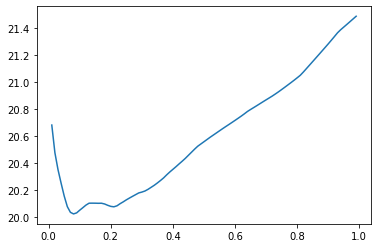

In [10]:
# loop to check out optimized alpha in Lasso model
alpha = []
error = []

for i in np.arange(0.01,1,0.01):
    alpha.append(i)
    lm_Lasso = Lasso(alpha = i,random_state = random_seed)
    error.append(np.mean(-1 * cross_val_score(lm_Lasso,X_train,y_train,scoring = 'neg_mean_absolute_error',cv=3)))
    
plt.plot(alpha,error);

In [11]:
optimal_alpha = alpha[np.argmin(error)]
lm_Lasso_opt = Lasso(alpha = optimal_alpha,random_state = random_seed)
lm_Lasso_opt.fit(X_train,y_train)
np.mean(-1 * cross_val_score(lm_Lasso_opt,X_train,y_train,scoring = 'neg_mean_absolute_error',cv=3))

20.024690411172497

In [12]:
# random forest model
rf = RandomForestRegressor(random_state = random_seed)
rf.fit(X_train,y_train)
np.mean(-1 * cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error',cv=3))

15.964976841169735

In [13]:
# tune RF model with GridsearchCV
parameters = {'n_estimators': range(10,200,10),
              'criterion': ('mse', 'mae'),
              'max_features': ('auto','sqrt', 'log2')}

gs = GridSearchCV(rf, parameters, scoring = 'neg_mean_absolute_error',cv=3)
gs.fit(X_train,y_train)

print(-1 * gs.best_score_)

15.317125800501435


In [14]:
gs.best_estimator_.set_params(random_state = random_seed)
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=130, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [15]:
# test all 3 methods
tpred_lm = lm.predict(X_test)
tpred_lml = lm_Lasso_opt.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

print("Multiple Linear Regression MAE = %.2f" % mean_absolute_error(y_test,tpred_lm))
print("Lasso Regression MAE = %.2f" % mean_absolute_error(y_test,tpred_lml))
print("Random Forest MAE = %.2f" % mean_absolute_error(y_test,tpred_rf))

Multiple Linear Regression MAE = 17.75
Lasso Regression MAE = 18.05
Random Forest MAE = 11.85
